In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Parse Data

In [45]:
# load runtime data for CNN
df_cnn = pd.read_csv("data/out/generalization/e7ivqipk_runtime.csv")
df_cnn.head()

,data,forward,peaks,load,scale
0,4.768372e-07,0.813986,0.341315,0.083782,1
1,9.536743e-07,0.001740,0.028811,0.083782,1
2,4.768372e-07,0.001262,0.026860,0.083782,1
3,1.192093e-06,0.001271,0.026304,0.083782,1
4,1.192093e-06,0.001249,0.026027,0.083782,1


In [46]:
# parse runtime data for LMCO data

# example: "data/sim_data/glmb/glmb_3.0k_10_600_0621_noclip_20markov/35/time_35.txt"
regex = re.compile(r"data/sim_data/(\w+)/[\w]+_(\d+).*/(\d+)/time_\d+\.txt")
data = []
for path in Path("data/sim_data").glob("**/time_*.txt"):
    match = regex.search(path.as_posix())
    if match is None:
        raise ValueError(f"Could not parse path: {path}")

    filter, scale, sim_idx = match.groups()
    data.append(
        {
            "filter": filter,
            "scale": int(scale),
            "sim_idx": int(sim_idx),
            "time": float(path.read_text().strip()) / 1000,
        }
    )
df_lmco = pd.DataFrame(data)
df_lmco.head()

,filter,scale,sim_idx,time
0,glmb,3,35,40.163188
1,glmb,3,29,36.008748
2,glmb,3,46,33.397767
3,glmb,3,67,27.816397
4,glmb,3,61,30.911956


In [47]:
# merge the two dfs
df_runtime = pd.concat(
    [
        df_cnn.assign(
            filter="cnn",
            time=df_cnn["forward"] + df_cnn["peaks"],
        )[["filter", "scale", "time"]],
        df_lmco[["filter", "scale", "time"]],
    ],
    ignore_index=True,
)

# Results

In [127]:
# summary stats
df_runtime["time_per_km2"] = df_runtime["time"] / df_runtime["scale"] ** 2
(
    df_runtime.groupby(["scale", "filter"])
    .agg({"time": ["mean", "std"], "time_per_km2": ["mean", "std"]})
    .round(2)
)

time        time_per_km2      
               mean    std         mean   std
scale filter                                 
1     cnn      0.04   0.11         0.04  0.11
      glmb     1.40   0.75         1.40  0.75
      lmb      1.32   0.96         1.32  0.96
2     cnn      0.07   0.01         0.02  0.00
      glmb     6.20   3.76         1.55  0.94
      lmb      4.39   3.81         1.10  0.95
3     cnn      0.19   0.03         0.02  0.00
      glmb    36.30  20.76         4.03  2.31
      lmb     10.48   6.05         1.16  0.67
4     cnn      0.45   0.05         0.03  0.00
5     cnn      1.06   0.11         0.04  0.00

In [161]:
# get the ratio of glmb to cnn and lmb to cnn
cnn_means = df_runtime.query("filter == 'cnn'").groupby("scale")["time"].mean()
(
    df_runtime.query("scale <= 3")
    .groupby(["scale", "filter"])["time"]
    .mean()
    .groupby("scale")
    .transform(lambda x: x / cnn_means)
    .to_frame()
    .rename(columns={"time_per_km2": "Speedup with CNN"})
    .round(0)
    .transpose()
)

scale     1                2                3             
filter  cnn  glmb   lmb  cnn  glmb   lmb  cnn   glmb   lmb
time    1.0  33.0  32.0  1.0  90.0  64.0  1.0  187.0  54.0

/home/damow/.pyenv/versions/3.11.4/envs/mtt/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/damow/.pyenv/versions/3.11.4/envs/mtt/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


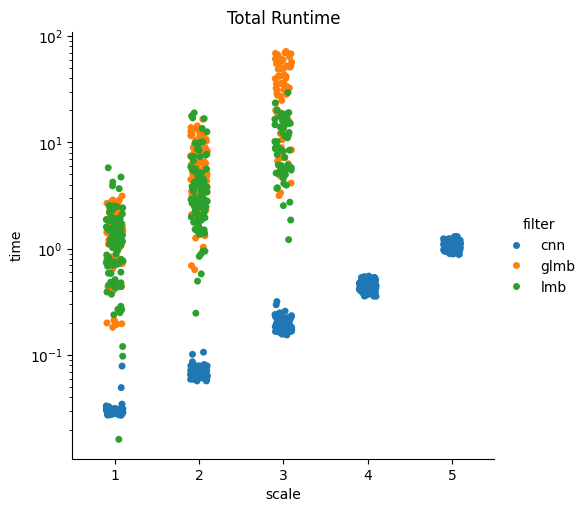

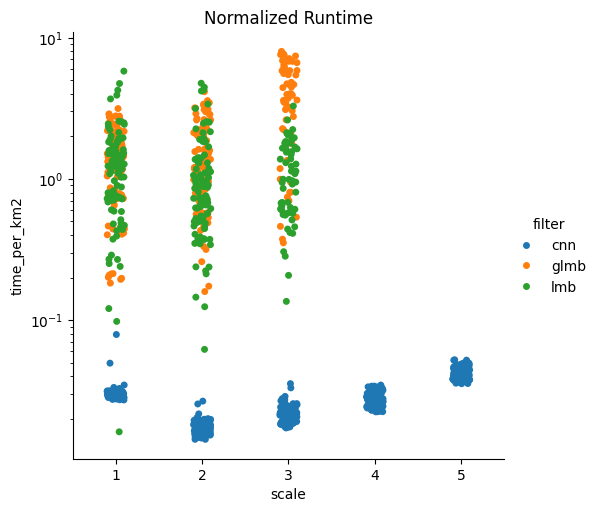

In [71]:
# summary plot

# Set log scale in y-axis

# Total Runtime
sns.catplot(data=df_runtime, x="scale", y="time", hue="filter")
plt.yscale("log")
plt.title("Total Runtime")

# Normalized Runtime
sns.catplot(data=df_runtime, x="scale", y="time_per_km2", hue="filter")
plt.yscale("log")
plt.title("Normalized Runtime")

plt.show()